<h1 align="center">INFO621 - RAG - XAI - PEFT Tuning [QWEN2 7B Local] </h1>



### This notebook / code was developed on Macbook Pro M3 - 128GB RAM (Local) and conda virtual env.
- Steps are mentioned in README.md.
- Create virtual Env
    -  run `conda env create -f environments.yaml`
    -  This install all packages and jupyter also
      -  This would create a virtual env named 'ml' 
    - `conda activate ml`
    - `jupyer notebook`
       - ---> and then open this notebook.
    - Change this to your local dir in cell 3  `local_path = '/Users/your_local_path`
    - We suggest running cell by cell manually to see the executions, as some steps are time consuming

- We expect with very little or no change, the same yaml file can be used in windows. But we have not tested it.
-  Would need your HuggingFace Token (to download the models)
  
#### Some steps take a long time to run, 
 - e.g. all the XAI frameworks may take few minutes to give results, RAGAS metrics are resource heavy.

### The code here uses QWEN-7B model for the E2E RAG pipeline + XAI + RAGAS evaluation
- Refer README.md for more details.
- And the Project report for combined study and analysis


### Core Libraries used in the project
 - **Core-ML/NLP**: torch, transformers, accelerate, bitsandbytes, sentence-transformers.
 - **Fine-Tuning**: peft, trl [PART OF ANOTHER NOTEBOOK]
 - **RAG & Vector Store**: langchain, chromadb, faiss-gpu
 - **Evaluation**: scikit-learn, **RAGAS**
 - **XAI**: captum, lime, shap, ,lit
 - **Data Handling**: datasets, numpy
 - **Utilities**: tqdm, psutil, asyncio, nest_asyncio, openai, tiktoken, matplotlib, seaborn

In [ ]:
# #  RUN FOR MACBOOK LOCAL

# OPTIONS


# a) from terminal, execute this to create env and install all dependencies
#    conda env create -f environments.yaml
#    -- This would create a virtual env named 'ml' 
#    conda activate ml
#    jupyer notebook ---> and then open this notebook. 


# b) Uncomment these below and install

# #  Core dependencies
# !pip install numpy==1.26.4
# !pip install matplotlib==3.10.1
# !pip install seaborn==0.13.2
# !pip install scikit-learn==1.6.1
# !pip install tqdm==4.67.1
# !pip install psutil==7.0.0
# !pip install faiss-cpu

# #  ML / NLP / LLMs
# !pip install torch==2.6.0
# !pip install accelerate==0.27.2
# !pip install transformers==4.50.3
# !pip install datasets==2.17.1
# !pip install sentence-transformers==3.4.1

# #  LangChain ecosystem
# !pip install langchain==0.1.15
# !pip install langchain-core==0.1.41
# !pip install langchain-community
# !pip install langchainhub

# #  RAG and Embeddings
# !pip install chromadb==1.0.5
# !pip install ragas==0.2.14

# #  Explainability / XAI
# !pip install captum==0.8.0
# !pip install lime==0.2.0.1
# !pip install shap==0.44.0

# #  Utilities
# !pip install openai
# !pip install nest_asyncio


In [2]:
#  Standard Library
import os
import re
import gc
import time
import asyncio
import warnings
from typing import List, Optional, Any
from collections import Counter

#  Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

#  Scientific & ML Libraries
import numpy as np
import torch
from torch.nn import functional as F
# import faiss
from tqdm import tqdm
import psutil
import shap
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Transformers / HuggingFace
import accelerate
from transformers import (
    pipeline, AutoTokenizer, AutoModelForCausalLM,
    AutoModelForSeq2SeqLM, GenerationConfig
)
from sentence_transformers import SentenceTransformer
from captum.attr import Saliency, IntegratedGradients
from captum.attr import visualization as viz

#  LangChain Core
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.llms.base import LLM
from langchain.schema import LLMResult, Document
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.callbacks.manager import CallbackManager, CallbackManagerForLLMRun
from langchain.chat_models import ChatOpenAI
from langchain.schema.retriever import BaseRetriever

#  LangChain Community Extensions
# from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings

#  LangChain Core v1-style
from langchain_core.retrievers import BaseRetriever as LCBaseRetriever
from langchain_core.documents import Document as LCDocument
from langchain_core.pydantic_v1 import Field

# RAGAS
from ragas import evaluate, EvaluationDataset
from ragas.run_config import RunConfig
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import BaseRagasEmbeddings, LangchainEmbeddingsWrapper
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness,
    AnswerCorrectness, ResponseRelevancy, ContextPrecision
)

#  Datasets
from datasets import Dataset, load_dataset

#  Notebook Setup
import nest_asyncio
nest_asyncio.apply()

#  Suppress Warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.")


In [3]:
# CHANGE ME
# for prototyping, we do not want to download models each time, so can save it locally 

local_path = '/Users/saurav1/python/masters/arizona/2nd/mlapps621/project/local_models/check'

In [4]:


# Langchain callback for detailed logging
CALLBACK_VERBOSE_LOGGING=True



## ==== 1) Load FEVER Dataset ====

In [5]:
# dataset1 = load_dataset("fever/feverous")
dataset1 = load_dataset("copenlu/fever_gold_evidence")

In [6]:
dataset1

DatasetDict({
    train: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 228277
    })
    validation: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 15935
    })
    test: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 16039
    })
})

In [7]:
train = dataset1['train']
validation = dataset1['validation']
test = dataset1['test']

## ==== 2) Cleaned FEVER Dataset ====

####  For the preprocessing of the dataset we remove:

- all words after the last dot
- Special terms like -LRB- etc
- all the digits that we found at the beginning of the sentence (also with the tab)
- all the parenthesis token strings
- all the words that contains characters that are not in ASCII format (for example the ones retrieved by the Wikipedia page for the pronunciation of a given name or term)
- all the punctuations etc


In [8]:


# Special tokens like "-LRB-" etc.
PARENTHESIS_TOKENS = {"-LRB-", "-LSB-", "-RRB-", "-RSB-"}

# Check for non-ASCII characters
def contains_non_ascii(s):
    return any(ord(ch) > 127 for ch in s)

# Remove parenthesis tokens
def remove_parenthesis(sentence):
    return ' '.join([word for word in sentence.split() if word not in PARENTHESIS_TOKENS])

# Clean up a single sentence
def clean_sentence(sentence):
    if not isinstance(sentence, str):
        return ""

    # 1. Remove trailing fragments after first period (optional)
    sentence = re.sub(r'(\.[^.]*)$', '.', sentence)

    # 2. Remove leading digits + tab
    sentence = re.sub(r'^\d+\t', '', sentence)

    # 3. Remove special parenthesis tokens like -LRB-, -RRB-, etc.
    sentence = re.sub(r'-LRB-|-RRB-|-LSB-|-RSB-', '', sentence)

    # 4. Remove words with non-ASCII characters
    words = sentence.split()
    words = [word for word in words if all(ord(ch) < 128 for ch in word)]
    sentence = ' '.join(words)

    # 5. Remove punctuation and underscores but KEEP dots and commas
    sentence = re.sub(r'[^\w\s.,]', '', sentence)

    # 6. Normalize whitespace
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = re.sub(r'[^\w\s.,]', '', sentence)
    sentence = re.sub(r'[_]', ' ', sentence)

    # 7. Lowercase
    sentence = sentence.lower().strip()
    if not (sentence.endswith(".")):
        sentence +=  "."
    return sentence

In [9]:
# === Extract and Clean Evidence Sentences ===
def clean_evidences(ds, max_len=500, typ="train"):
    evidence_sentences = []
    total = 0
    for example in ds:
        if 'evidence' in example and example['evidence']:
            total += 1
            for group in example['evidence']:
                full_sent = ""
                for ev in group:
                    if isinstance(ev, str) and not ev.isdigit():
                        sentence = clean_sentence(ev)
                        if sentence:
                            full_sent += sentence + " "
                if full_sent.strip():
                    evidence_sentences.append(full_sent.strip()[0:max_len])
    
    # Deduplicate
    evidence_sentences = list(set(evidence_sentences))
    print("total ", total)
    print(f"Total cleaned evidence dedup sentences : {len(evidence_sentences)}, of {typ}")
    for e in evidence_sentences[:2]:
        print("Sample:", e)
    return evidence_sentences

In [10]:
# Use only 5,000 for our purpose.
train_10K=train.select(range(5000))
train_cl_10K = clean_evidences(train_10K)


total  5000
Total cleaned evidence dedup sentences : 4863, of train
Sample: jyothika. she made a comeback in the film 36 vayadhinile 2015 , which received good reviews from the critics , especially for her performance and she received filmfare critics award for best actress for the movie .
Sample: joint aviation requirements. jaa certification specifications , formerly known as jars , are recognised by easa as an acceptable basis for showing compliance with their national airworthiness codes .


In [11]:
# Use 1000 for validation
validation_1K=validation.select(range(1000))
validation_cl_1K = clean_evidences(validation_1K, typ="validation")


total  1000
Total cleaned evidence dedup sentences : 925, of validation
Sample: tom delonge. he formed blink182 with bassist mark hoppus and drummer scott raynor during his high school years .
Sample: 2016 tour de france. a total of 198 riders from 22 teams entered the 21stage race , which was won by chris froome of .


In [12]:
# Use 1000 for test
test_1K=test.select(range(1000))
test_cl_1K = clean_evidences(test_1K, typ="test")

total  1000
Total cleaned evidence dedup sentences : 910, of test
Sample: jason bourne film. jason bourne is a 2016 american action thriller film directed by paul greengrass written by greengrass and christopher rouse .
Sample: the spongebob squarepants movie. the film was directed by series creator stephen hillenburg and starred the series cast of tom kenny , bill fagerbakke , clancy brown , rodger bumpass and mr. lawrence , with guest performances by scarlett johansson , jeffrey tambor , alec baldwin and david hasselhoff .


## Pie Chart Code for Class Distribution

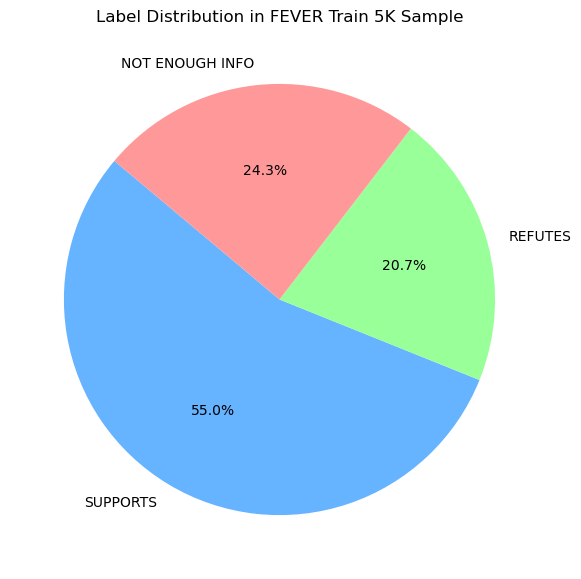

In [13]:


# Count label distribution
label_counts = Counter([sample["label"] for sample in train_10K])

# Plot
labels = list(label_counts.keys())
sizes = list(label_counts.values())
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
# plt.axis("equal")
plt.title("Label Distribution in FEVER Train 5K Sample")
plt.show()

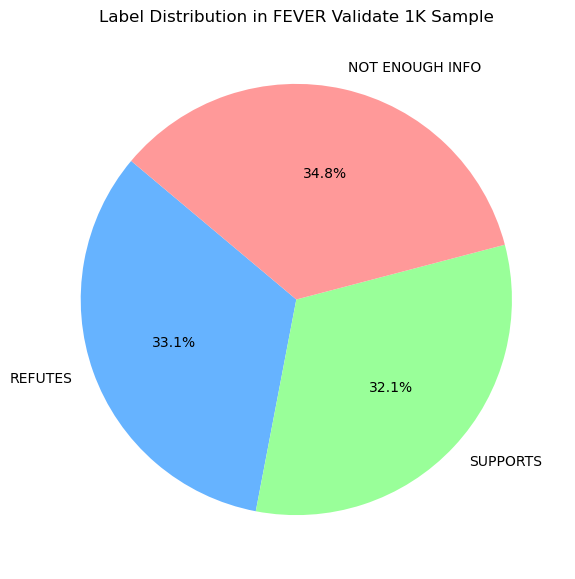

In [14]:
# Count label distribution
label_counts = Counter([sample["label"] for sample in validation_1K])

# Plot
labels = list(label_counts.keys())
sizes = list(label_counts.values())
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
# plt.axis("equal")
plt.title("Label Distribution in FEVER Validate 1K Sample")
plt.show()

## === 3. Embedding Model ===

In [15]:
def get_embedding_model(model_name: str = "BAAI/bge-m3", save_path: str = "./local_models/bge-m3"):
    """
    Downloads and saves a sentence-transformer model if not already saved.
    Returns a HuggingFaceEmbeddings instance for LangChain.
    
    Args:
        model_name (str): Name of the Hugging Face model.
        save_path (str): Local directory to save/load the model.

    Returns:
        HuggingFaceEmbeddings: Embedding wrapper usable with LangChain retrievers.
    """
    if not os.path.exists(save_path):
        print(f"Downloading and saving model '{model_name}' to: {save_path}")
        model = SentenceTransformer(model_name)
        
        model.save(save_path)
    else:
        print(f"Loading embedding model from local path: {save_path}")

    model = HuggingFaceEmbeddings(model_name=save_path)
    sentence_transformer = SentenceTransformer(save_path)
    
    return model, sentence_transformer

In [16]:
embedding_model, sentence_transformer = get_embedding_model(
    model_name="BAAI/bge-m3",
    save_path=local_path + "/bge-m3"
)

Loading embedding model from local path: /Users/saurav1/python/masters/arizona/2nd/mlapps621/project/local_models/check/bge-m3


## === 4. Chroma Vector Store ===



In [17]:
def monitor_memory():
    mem = psutil.virtual_memory()
    return f"Memory used: {mem.used // (1024**2)} MB / {mem.total // (1024**2)} MB ({mem.percent}%)"

def get_or_create_chroma_db(texts, embedding_model, persist_dir, batch_size=100):
    if os.path.exists(persist_dir):
        print("Loading existing Chroma DB from disk...")
        return Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
    else:
        # return Chroma.from_texts(texts, embedding=embedding_model, persist_directory=persist_dir)
        print("Creating new Chroma DB and saving to disk...")
        print("given size ", len(texts))
        os.makedirs(persist_dir, exist_ok=True)

        # Create Chroma DB (empty)
        vectorstore = Chroma(embedding_function=embedding_model, persist_directory=persist_dir)
    
        for i in tqdm(range(0, len(texts), batch_size), desc="Indexing to Chroma"):
            batch = texts[i:i + batch_size]
            if batch:
                try:
                    vectorstore.add_texts(batch)
                    vectorstore.persist()  # flush to disk
                except Exception as e:
                    print(f"Skipped batch {i}: {e}")
                    raise
            gc.collect()  # clean up memory

        return vectorstore
        

In [18]:
# TRAIN Chroma DB
evidence_sentences = train_cl_10K
vectorstore = get_or_create_chroma_db(
    texts=evidence_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_train"
)
print (len(vectorstore))

Loading existing Chroma DB from disk...
4863


In [19]:
# VALIDATE Chroma DB
validation_sentences = validation_cl_1K
vectorstore_validate = get_or_create_chroma_db(
    texts=validation_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_validate"
)
print (len(validation_sentences))

Loading existing Chroma DB from disk...
925


# ==== 5 The model ====

In [20]:
# from huggingface_hub import login
# login(token="your_huggingface_token_here")

In [21]:
def load_or_download_model(model_id="Qwen/Qwen2-7B-Instruct", local_dir=local_path+"/path"):
    """
    Loads model from local directory if it exists,
    otherwise downloads and saves it to the specified path.

    Returns:
        tokenizer, model
    """
    if os.path.exists(local_dir) and os.path.isdir(local_dir):
        print(f" Loading model from local path: {local_dir}")
        tokenizer = AutoTokenizer.from_pretrained(local_dir)
        model = AutoModelForCausalLM.from_pretrained(local_dir, device_map="auto", torch_dtype="auto")
    else:
        print(f" Downloading model from Hugging Face: {model_id}")
        tokenizer = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto")
        print(f" Saving model to: {local_dir}")
        tokenizer.save_pretrained(local_dir)
        model.save_pretrained(local_dir)

    return tokenizer, model

In [22]:
tokenizer, model = load_or_download_model(local_dir=local_path + "/qwen2-7b-instruct")



Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

 Saving model to: /Users/saurav1/python/masters/arizona/2nd/mlapps621/project/local_models/check/qwen2-7b-instruct


In [23]:
# Create a generation pipeline
gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512, # TODO 1024 in colab
    pad_token_id=tokenizer.eos_token_id,  # this prevents the warning
    temperature=0.1,
    do_sample=True,
    top_p=0.95,
    # return_full_text=False
)

Device set to use mps


In [24]:

# Wrap in LangChain LLM
llm = HuggingFacePipeline(pipeline=gen_pipeline)

### ===  DenseRetriever &  MultiQueryRetriever Setup ===



In [25]:
# Expand query → Dense retrieve
# retriever = MultiQueryRetriever.from_llm(
#    retriever=vectorstore.as_retriever(search_kwargs={"k": 5}),
#    llm=llm # ChatOpenAI(temperature=0)  # Replace with HuggingFacePipeline if local-only
# )

# Vanilla retriever worked better than MultiQuery one and provided relevant evidence on top.
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})


In [26]:
# Dense retriever
retriever_validate = vectorstore_validate.as_retriever(search_kwargs={"k": 5})

## === 6. Reasoning Prompt ===

In [27]:

# prompt_template = PromptTemplate.from_template("""
# You are a classifier. Based ONLY on the evidence below, select the correct label for the claim: 
# SUPPORTS, REFUTES, or NOT ENOUGH INFO. Respond with only one word. If the claim entity is mentioned but no positive link exists, treat as REFUTES.

# Claim: {question}

# Evidence:
# {context}

# Your answer:
# """)

prompt_template = PromptTemplate.from_template(
    """<|im_start|>system
You are a fact-checking assistant. Classify the Claim based only on the Evidence. Respond with exactly one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO.<|im_end|>
<|im_start|>user
Claim: {question}

Evidence:
{context}

Answer with one of: SUPPORTS / REFUTES / NOT ENOUGH INFO.
<|im_end|>
<|im_start|>assistant
"""
)

In [28]:

def extract_label_from_answer_block(text):
    """
    Extracts the final label from the line after 'Your answer:' in the model's response.
    Assumes label is one of: SUPPORTS, REFUTES, NOT ENOUGH INFO
    """
    valid_labels = {"SUPPORTS", "REFUTES", "NOT ENOUGH INFO"}

    # Find the last <|im_start|>assistant tag
    parts = text.lower().split("<|im_start|>assistant")
    if len(parts) < 2:
        return "UNKNOWN"

    # Only parse what comes after the final assistant tag
    answer_block = parts[-1].strip().upper()

    # Look for the first valid label as a full word
    for line in answer_block.splitlines():
        line = line.strip(" .:\n").upper()
        if line in valid_labels:
            return line

    return "UNKNOWN"

## === 7. RAG Chain ===

**Async Retrieval**
- Class that performs threshold-based evidence filtering for the RAG pipeline:
- Instead of naively using top 5 documents, it selects top K/5 which show cosine_simuilarity > threshold of 0.6
- 0.6 was empirically selected after doing analysis over 100s of claim outputs.
- Participates in end to end Chain Logging (retrival logging)

In [29]:
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import LLMResult

class VerboseCallbackHandler(BaseCallbackHandler):
    """
    A detailed callback handler for monitoring and logging RAG pipeline steps, 
    including chain execution, retriever outputs, LLM prompts, LLM responses, 
    streaming tokens, and token usage.

    This handler is primarily used for debugging and analyzing pipeline behavior 
    by printing human-readable logs during retrieval, generation, and chain execution.

    Args:
        enabled (bool, optional): 
            Whether verbose logging is globally enabled. Defaults to True.
        
        print_prompt (bool, optional): 
            Whether to print LLM input prompts. Defaults to True.
        
        print_docs (bool, optional): 
            Whether to print retrieved documents' contents. Defaults to True.

    Attributes:
        enabled (bool): 
            Controls whether any logging is performed.
        
        print_prompt (bool): 
            Controls whether LLM prompts are displayed.
        
        print_docs (bool): 
            Controls whether retrieved documents are displayed.
        
        _timers (dict): 
            Internal dictionary to track timing information for different pipeline stages.

    """
    
    def __init__(self, enabled=True, print_prompt=True, print_docs=True):
        self.enabled = enabled
        self.print_prompt = print_prompt
        self.print_docs = print_docs
        self._timers = {}

    def _start_timer(self, key):
        self._timers[key] = time.time()
    
    def _end_timer(self, key):
        if key in self._timers:
            elapsed = time.time() - self._timers[key]
            print(f"⏱️ [Time] {key} took {elapsed:.2f} sec")
    
    def on_chain_start(self, serialized, inputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [Chain Start]")
        print(f"  ➤ Query: {inputs.get('query', inputs)}")
        self._start_timer("Chain")
        
    def on_chain_end(self, outputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("Chain")
        print(" [Chain End]")
        print(f"  ➤ Output: {outputs}")

    def on_retriever_end(self, documents, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print(f" [Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")

    def on_llm_start(self, serialized, prompts, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [LLM Prompt]")
        print(prompts[0][:1000])  # Truncate long prompts
        self._start_timer("LLM")
        
    def on_llm_end(self, response: LLMResult, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("LLM")            
        print("\n [LLM Response]")
        print(response.generations[0][0].text.strip())

    def on_llm_new_token(self, token: str, **kwargs):
        if CALLBACK_VERBOSE_LOGGING:
            print(token, end='', flush=True)

    def on_llm_end_streaming(self, **kwargs):
        if v:
            print()  # for clean newline after token stream

    def on_llm_token_usage(self, token_usage: dict, **kwargs):
        if  CALLBACK_VERBOSE_LOGGING:
            print(f"\n [Token Usage] prompt: {token_usage.get('prompt_tokens')}, "
                  f"completion: {token_usage.get('completion_tokens')}, "
                  f"total: {token_usage.get('total_tokens')}")
    
    def log_docs(self, documents):
        if not CALLBACK_VERBOSE_LOGGING: return
        print(f"[Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")            


#### Threshold Filtering Retriever
-  Extends the Retriever for RAGs and filters any documents having cosine similarity less than given threshold to offer more relevant and less documents to Model context

In [30]:


from typing import List, Optional, Any
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import Field
from sklearn.metrics.pairwise import cosine_similarity
import time

class ThresholdFilteredRetriever(BaseRetriever):
    """
    A retriever that filters documents retrieved from a base retriever 
    based on a cosine similarity threshold using a query embedding.

    This retriever works by:
      1. Retrieving candidate documents using a base retriever.
      2. Computing embeddings for the query and documents.
      3. Filtering documents whose cosine similarity to the query 
         is below a specified threshold.
      4. Falling back to selecting top-k documents if no documents 
         pass the threshold.

    This improves retrieval precision by ensuring only semantically 
    relevant documents (above a threshold) are considered.

    Args:
        base_retriever (BaseRetriever): 
            The underlying retriever to fetch initial candidate documents.
        
        embedding_model (Any): 
            Embedding model providing `embed_query()` and `embed_documents()` 
            methods for vectorization.
        
        threshold (float, optional): 
            Minimum cosine similarity score to retain a document. Defaults to 0.65.
        
        fallback_topk (int, optional): 
            Number of top documents to fallback to if none meet the threshold. Defaults to 1.
        
        callback_handler (Optional[Any], optional): 
            Optional callback handler for logging document retrieval details.

    Attributes:
        total_queries (int): 
            Total number of queries processed.
        
        total_docs_returned (int): 
            Total number of documents returned across all queries.
        
        total_retrieval_time (float): 
            Total time spent on retrieval operations (in seconds).
    """
    
    base_retriever: Any = Field()
    embedding_model: Any = Field()
    threshold: float = Field(default=0.65)
    fallback_topk: int = Field(default=1)
    callback_handler: Optional[Any] = Field(default=None)

    total_queries: int = Field(default=0)
    total_docs_returned: int = Field(default=0)
    total_retrieval_time: float = Field(default=0.0)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        start = time.time()
        self.total_queries += 1
    
        # Support LCEL-wrapped retriever
        raw_docs = self.base_retriever.invoke(query)
        doc_texts = [doc.page_content for doc in raw_docs]
    
        if not doc_texts:
            return []
    
        query_emb = self.embedding_model.embed_query(query)
        doc_embs = self.embedding_model.embed_documents(doc_texts)
        sim_scores = cosine_similarity([query_emb], doc_embs)[0]
    
        filtered = [(raw_docs[i], sim_scores[i]) for i in range(len(raw_docs)) if sim_scores[i] >= self.threshold]
    
        if not filtered:
            sorted_docs = sorted(zip(raw_docs, sim_scores), key=lambda x: -x[1])
            filtered = sorted_docs[:self.fallback_topk]
    
        final_docs = [doc for doc, _ in filtered]
        self.total_docs_returned += len(final_docs)
        self.total_retrieval_time += (time.time() - start)
    
        if self.callback_handler:
            self.callback_handler.log_docs(final_docs)
    
        return final_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

    def print_metrics(self):
        if self.total_queries > 0:
            avg_time = self.total_retrieval_time / self.total_queries
            avg_docs = self.total_docs_returned / self.total_queries
        else:
            avg_time = avg_docs = 0
        print(f"\n Retrieval Metrics")
        print(f"  ➤ Total Queries: {self.total_queries}")
        print(f"  ➤ Avg Time per Query: {avg_time:.3f} sec")
        print(f"  ➤ Avg Docs Returned: {avg_docs:.2f}")



In [31]:

callback = ConsoleCallbackHandler()

# Toggle logging
CALLBACK_VERBOSE_LOGGING=True

callback_handler = VerboseCallbackHandler(enabled=CALLBACK_VERBOSE_LOGGING)
callback_manager = CallbackManager([callback_handler])

# llm.callback_manager = callback_manager
retriever = retriever.with_config(callbacks=[callback_handler])
llm = llm.with_config(callbacks=[callback_handler])

# Wrap your retriever with threshold logic
filtered_retriever_train = ThresholdFilteredRetriever(
    base_retriever=retriever,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler 
)

tagged_rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=filtered_retriever_train,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template},
    callbacks=[callback_handler],  #  Add callback
    verbose=False
)

In [32]:
filtered_retriever_validate = ThresholdFilteredRetriever(
    base_retriever=retriever_validate,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler 
)


tagged_rag_chain_validate = RetrievalQA.from_chain_type(
	    llm=llm,
	    retriever=filtered_retriever_validate,
	    chain_type="stuff",
	    return_source_documents=True,
	    chain_type_kwargs={"prompt": prompt_template}
)

In [33]:
gc.collect()
CALLBACK_VERBOSE_LOGGING=False

### Compare Async Vs Sync Retrieval from Vector DB

In [34]:

nest_asyncio.apply()

claims = [train_10K[i]['claim'] for i in range(5)]  # your 100 claims

# Sync
start = time.time()
sync_results = [tagged_rag_chain.invoke({"query": c}) for c in claims]
sync_time = time.time() - start
print(f" Sync: {sync_time:.2f} sec")

# ASYNC
async def run_async_batch():
    tasks = [tagged_rag_chain.ainvoke({"query": c}) for c in claims]
    return await asyncio.gather(*tasks)

start = time.time()
async_results = await run_async_batch() 
async_time = time.time() - start
print(f" Async: {time.time() - start:.2f} sec")


 Sync: 5.80 sec
 Async: 2.08 sec


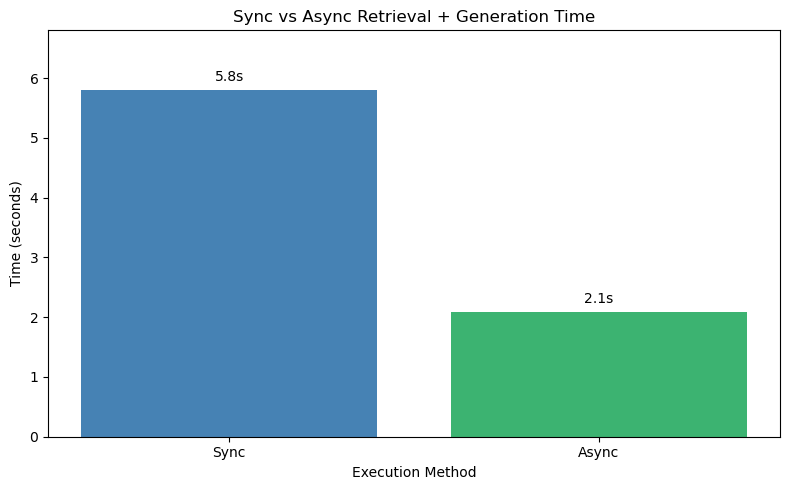

In [35]:

# Bar chart setup
methods = ['Sync', 'Async']
times = [sync_time, async_time]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, times, color=["steelblue", "mediumseagreen"])
plt.title("Sync vs Async Retrieval + Generation Time")
plt.ylabel("Time (seconds)")
plt.xlabel("Execution Method")

# Annotate bars neatly above center
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f"{yval:.1f}s", ha='center', va='bottom')

plt.ylim(0, max(times) + 1)
plt.tight_layout()
plt.show()


## 7a. EXECUTION on one Claim

In [36]:
# Run just one sample for explainability
CALLBACK_VERBOSE_LOGGING=True
sample = train_10K[200]
claim = sample['claim']
result = tagged_rag_chain({"query": claim})
documents = result['source_documents']
doc_texts = [doc.page_content for doc in documents]



 [Chain Start]
  ➤ Query: Suicide Kings is a film from the United States.
 [Retriever] Retrieved 5 documents:
  1. suicide kings. suicide kings is a 1997 american mystery crime film based on don stanford s short story the hostage and directed by peter ofallon ....
  2. remote control productions. remote control productions has been responsible for the scores for a number of successful liveaction films including the p...
  3. get out film. get out is a 2017 american horror film written , coproduced and directed by jordan peele , in his directorial debut ....
[Retriever] Retrieved 1 documents:
  1. suicide kings. suicide kings is a 1997 american mystery crime film based on don stanford s short story the hostage and directed by peter ofallon ....

 [LLM Prompt]
<|im_start|>system
You are a fact-checking assistant. Classify the Claim based only on the Evidence. Respond with exactly one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO.<|im_end|>
<|im_start|>user
Claim: Suicide Kings is a film fro

In [37]:
# print(result['source_documents'])
# print(result['result'])

In [38]:
pred_label = extract_label_from_answer_block(result["result"])
print("actual=",sample['label'],", predicted=",pred_label)

actual= SUPPORTS , predicted= SUPPORTS


In [39]:
# Turn OFF the DETAILED LLM Chain LOGGING 
CALLBACK_VERBOSE_LOGGING=False

# === 8 a). Explainable AI (Captum Saliency) ===

In [41]:
def build_input_text_with_evidence(claim, doc_texts, tokenizer, max_tokens=512):
    """
    Safely build a prompt including the claim and as many evidence chunks as fit within max_tokens.
    
    Args:
        claim (str): The claim string.
        doc_texts (list): List of evidence strings.
        tokenizer: HuggingFace tokenizer to count tokens.
        max_tokens (int): Max allowed token length (for Mistral, keep ≤ 2048, safer ~512-1024).

    Returns:
        str: Truncated prompt with claim + partial evidence.
    """
    header = f""
    current_token_count = len(tokenizer.encode(header))
    
    included_evidence = []
    
    for i, doc in enumerate(doc_texts):
        entry = f"{i+1}. {doc.strip()}\n"
        tokens = len(tokenizer.encode(entry))
        if current_token_count + tokens <= max_tokens:
            included_evidence.append(entry)
            current_token_count += tokens
        else:
            break
    
    return header + "".join(included_evidence)

In [42]:
# model.eval()

label_token = pred_label  # or REFUTED, etc.
# Tokenize the full prompt + evidence
# input_text = f"{claim}\n" + "\n".join(doc_texts) 
# input_text = prompt_template.format(question=claim, context="\n".join(doc_texts))

context = build_input_text_with_evidence(claim, doc_texts, max_tokens=512, tokenizer=tokenizer)
input_text = prompt_template.format(question=claim, context=context)

# Tokenize input
inputs = tokenizer(input_text, return_tensors="pt")
input_ids = inputs["input_ids"].to(model.device)
attention_mask = inputs["attention_mask"].to(model.device)

# Get input embeddings for Captum
input_embeddings = model.get_input_embeddings()(input_ids)
input_embeddings.requires_grad_()

# Token ID of predicted label
label_token_id = tokenizer(pred_label, add_special_tokens=False)["input_ids"][0]
print(label_token_id)

# === 3. Define a forward function that returns scalar logit for predicted label ===

def forward_func(embeddings):
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    return outputs.logits[:, -1, label_token_id]  # Attribution at position the model starts generating


50


In [43]:
ig = IntegratedGradients(forward_func)
attributions, delta = ig.attribute(input_embeddings, 
                            internal_batch_size=1,
                            return_convergence_delta=True, 
                            n_steps=30) # TODO : make it 20 or 30 for COLAB

In [44]:
# Normalize and summarize
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    return attributions / torch.norm(attributions)
    
summarized = summarize_attributions(attributions)    

In [45]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
scores = summarized.detach().cpu().to(torch.float32).numpy()

# Pair tokens and scores, sort
token_score_pairs = list(zip(tokens, scores))
sorted_pairs = sorted(token_score_pairs, key=lambda x: x[1], reverse=True)


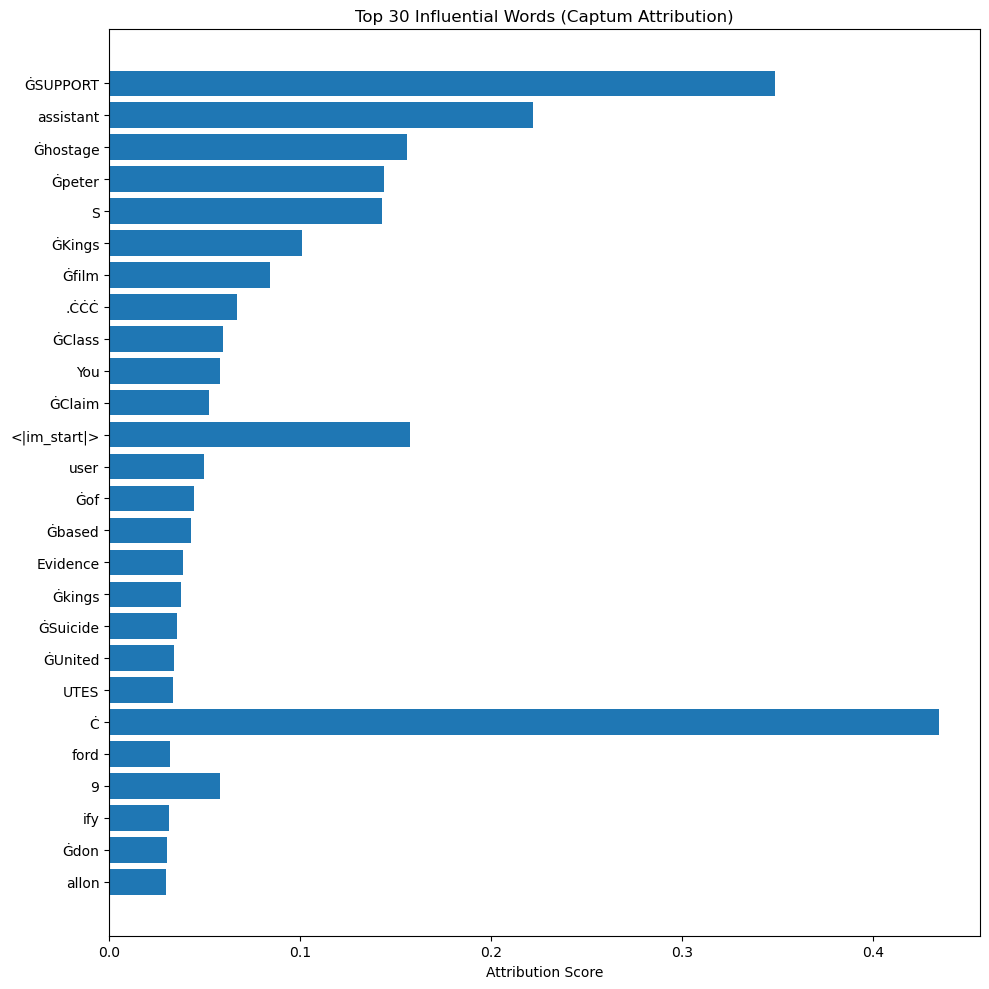

In [46]:
merged = zip (tokens, scores)
merged_words = sorted(merged, key=lambda x: x[1], reverse=True)

# Plot
# Take top 20 words by attribution score
top_words = merged_words[:30]
words, word_scores = zip(*top_words)

# print (words)
# print (word_scores)
# Plot
plt.figure(figsize=(10, 10))
plt.barh(words[0:][::-1], word_scores[0:][::-1])
plt.xlabel("Attribution Score")
plt.title("Top 30 Influential Words (Captum Attribution)")
plt.tight_layout()
plt.show()

### Heatmap of top token attributions

In [47]:

def normalize_percentile(scores, low=2, high=98):
    arr = np.array(scores)
    vmin = np.percentile(arr, low)
    vmax = np.percentile(arr, high)
    vmax = max(vmax, vmin + 1e-6)  # prevent divide-by-zero
    return arr, vmin, vmax
    
def highlight_tokens_colored(merged_words, cmap=matplotlib.cm.coolwarm, use_percentile=True):
    raw_scores = [score for _, score in merged_words]

    if use_percentile:
        scores, vmin, vmax = normalize_percentile(raw_scores)
    else:
        scores = np.array(raw_scores)
        vmin, vmax = min(scores), max(scores) + 1e-6

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    html = ""
    for (word, _), score in zip(merged_words, scores):
        rgba = cmap(norm(score))
        r, g, b, _ = [int(x * 255) for x in rgba]
        html += f'<span style="background-color: rgba({r},{g},{b}, 0.6); padding:2px; margin:1px;">{word}</span> '

    display(HTML(f"<div style='font-family:monospace; line-height:1.6;'>{html}</div>"))

highlight_tokens_colored(merged_words)

In [48]:

tokens = tokens[:500]
scores = scores[:500]

record = viz.VisualizationDataRecord(
    scores,                 # word_attributions
    0.0,                    # pred_prob
    pred_label,            # pred_class
    sample['label'],            # true_class
    sample['label'],            # attr_class
    scores.sum(),           # attr_score
    tokens,                 # raw_input (tokens as list)
    delta.item()                       # convergence_score (use 0 if not IG)
)

viz.visualize_text([record])

### Notes
**Qwen does not do well with transformers interpretability tools like Captum out of the box**
- how Qwen2 handles tokenization and special tokens (especially <|im_start|> and <|im_end|>), which are incompatible with captum.
- these result in long, untokenizable chunks making word-level attribution meaningless. like: "<|im_start|>systemĊYouĠareĠaĠfact-checking."
- Captum relies on token-level gradients, and these merged/special tokens prevent correct parsing or alignment between input and model output logits



##  === 8 b). Explainable AI - Prompt-based Rationales (Soft XAI) === 

- **Add an additional prompt turn that forces the model to verbalize why it chose a label**
- 

In [49]:
# --- Load Dataset (100 claims) ---
# eval_subset = validation.select(range(50))


# --- Prompt Template ---
prompt_template_temp = """<|im_start|>system
You are a helpful fact-checking assistant.<|im_end|>
<|im_start|>user
Claim: {claim}

Evidence:
{evidence}

Task: Based on the above, classify the claim as SUPPORTS, REFUTES, or NOT ENOUGH INFO. Then briefly explain why.
Also tell which tokens from claim and evidence it focussed most on or were of highest attention
<|im_end|>
<|im_start|>assistant
Label: 
Reason: 
Focussed Tokens:
"""
claim = sample['claim']
prompt = prompt_template_temp.format(claim=claim, evidence=doc_texts[0])
response = gen_pipeline(prompt, do_sample=False)[0]['generated_text'].upper()
print(response)

<|IM_START|>SYSTEM
YOU ARE A HELPFUL FACT-CHECKING ASSISTANT.<|IM_END|>
<|IM_START|>USER
CLAIM: SUICIDE KINGS IS A FILM FROM THE UNITED STATES.

EVIDENCE:
SUICIDE KINGS. SUICIDE KINGS IS A 1997 AMERICAN MYSTERY CRIME FILM BASED ON DON STANFORD S SHORT STORY THE HOSTAGE AND DIRECTED BY PETER OFALLON .

TASK: BASED ON THE ABOVE, CLASSIFY THE CLAIM AS SUPPORTS, REFUTES, OR NOT ENOUGH INFO. THEN BRIEFLY EXPLAIN WHY.
ALSO TELL WHICH TOKENS FROM CLAIM AND EVIDENCE IT FOCUSSED MOST ON OR WERE OF HIGHEST ATTENTION
<|IM_END|>
<|IM_START|>ASSISTANT
LABEL: 
REASON: 
FOCUSSED TOKENS:
EXPLANATION:

LABEL: SUPPORTS

REASON: THE EVIDENCE CLEARLY STATES THAT "SUICIDE KINGS" IS AN AMERICAN FILM, SPECIFICALLY MENTIONING IT AS A "1997 AMERICAN MYSTERY CRIME FILM". THIS DIRECTLY SUPPORTS THE CLAIM THAT "SUICIDE KINGS" IS A FILM FROM THE UNITED STATES.

FOCUSSED TOKENS:
- "AMERICAN"
- "DIRECTED BY PETER OFALLON" ( (IMPLIED TO BE A DETAIL ABOUT ITS ORIGIN RATHER THAN A SEPARATE POINT)


#### Insights
- We can see above that when asked, model provided it's reasoning for reaching the conclusion.
- Provided most focussed tokens 

## === 8 c). Explainable AI - SHAP for XAI -


In [50]:


def qwen2_predict(texts):
    # Make sure each input is converted to plain Python string
    str_inputs = [str(t) for t in texts]
    results = gen_pipeline(str_inputs, max_new_tokens=30)

    outputs = []
    for res in results:
        output_text = extract_label_from_answer_block(res[0]["generated_text"].upper())
        if "SUPPORTS" in output_text:
            outputs.append([1, 0, 0])
        elif "REFUTES" in output_text:
            outputs.append([0, 1, 0])
        else:
            outputs.append([0, 0, 1])
    return np.array(outputs)
   

In [51]:

explainer = shap.Explainer(qwen2_predict, tokenizer)
shap_values = explainer([prompt_template.format(question=claim, context = doc_texts[0])])
shap.plots.text(shap_values[0])  # Visual heatmap 

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:16, 256.32s/it]                                                                                                       


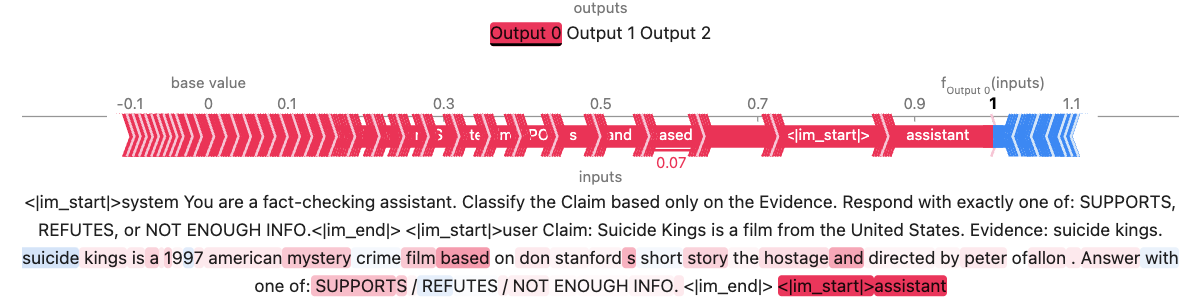

#### Commentary on SUPPORTS token attribution output from SHAP
**Middle: Contribution Graph**
- This is a SHAP waterfall bar of contributions to the "SUPPORTS" prediction
- Tokens that increase belief in SUPPORTS are red → rightward arrows
- Tokens that decrease belief in SUPPORTS are blue → leftward arrows


- "film" and "american" strongly support the SUPPORTS prediction
- "<|im_start|>" or padding-like tokens like "uic" pull it slightly away

**Bottom: Token-level Explanation**

Token coloring:

- 🔴 Red (positive contribution): Tokens like "film", "american", "based", "story", "assistant" contributed to predicting SUPPORTS
- 🔵 Blue (negative contribution): Tokens like parts of special tokens (e.g., <|im_start|>) slightly reduced the likelihood of SUPPORTS


**This shows that the claim was classified as SUPPORTS because of words like:**
- "film based on...", "american mystery crime...", "story the hostage..."
- These indicate the model found evidence tightly aligned with the claim.

**The 2nd Tab output for above**
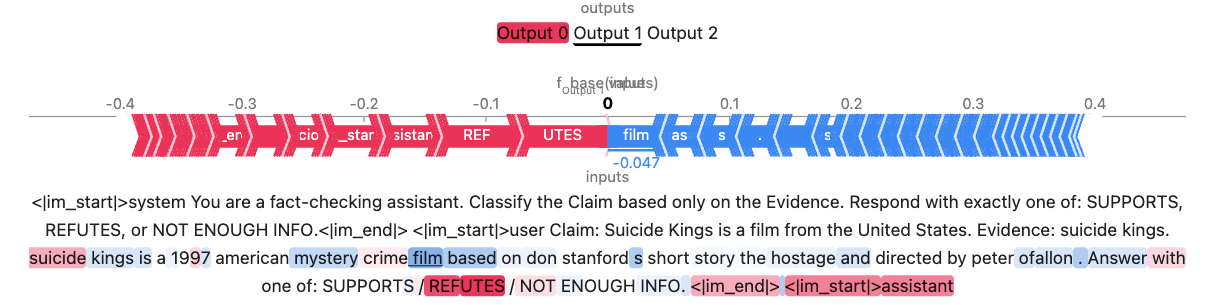

#### Sample Output when Model Predicts REFUTES
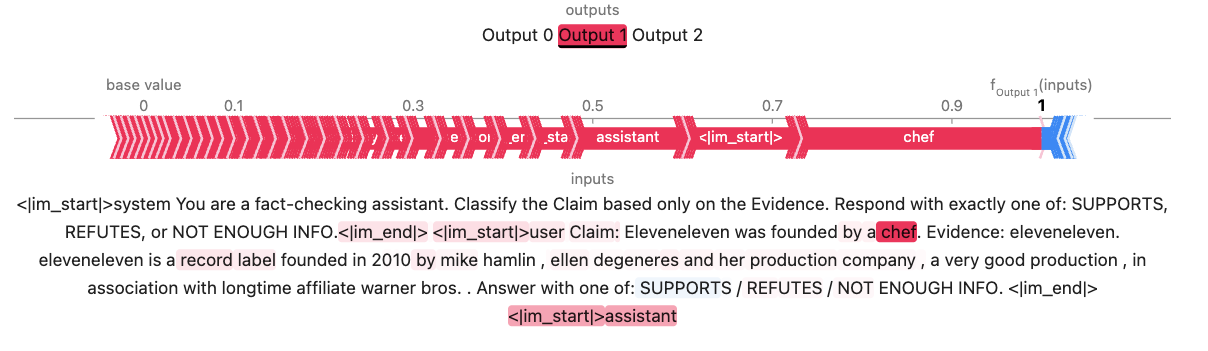

##  === 8 d). Explainable AI - LIME Integration

In [52]:

CALLBACK_VERBOSE_LOGGING=False
# Return probability-like dummy scores (e.g., for 3 labels)
def lime_predict(texts):
    outputs = []
    for text in texts:
        result = gen_pipeline(text, max_new_tokens=512)[0]['generated_text']
        lb = extract_label_from_answer_block(result)
        if "SUPPORTS" in lb:
            outputs.append([1, 0, 0])
        elif "REFUTES" in lb:
            outputs.append([0, 1, 0])
        else:
            outputs.append([0, 0, 1])
    return np.array(outputs)

In [55]:
class_names = ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]
explainer = LimeTextExplainer(class_names=class_names,  bow=False)

exp = explainer.explain_instance(
    prompt_template.format(
        question=claim,
        context="\n".join(doc_texts)
    ).split("Claim:")[1],
    lime_predict,
    num_features=30, # TODO INC
    num_samples=3 # TODO INC
)
exp.show_in_notebook(text=True)

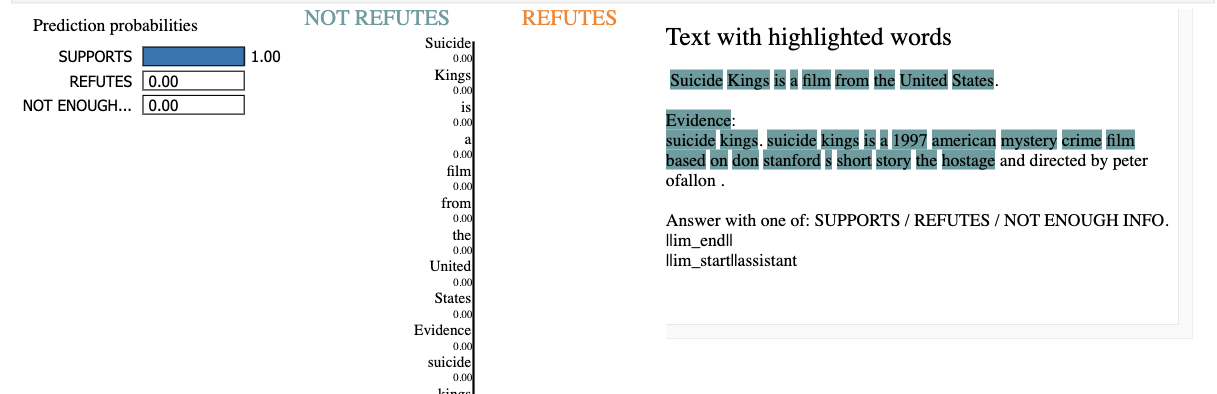

**Insights**
- LIME highlights the tokens like "suicide kings", "1997 american mystery crime film" etc from claim and evidence.
- Why scores are 0.0 could be due to rounding errors or inexplicable.
- The num_features and samples if increased could give more relevant insights

##  === 8 e). Explainable AI --  LangChain Callbacks: Full Pipeline Logging ===

**Below we showcase complete Rag chain pipeline tracing**
- From retriever, to evidence collected, and LLM decision
- Time logged at each stage

In [56]:
CALLBACK_VERBOSE_LOGGING=True
sample = train_10K[201]
claim = sample['claim']
result = tagged_rag_chain({"query": claim})
print("label=",sample['label'])
CALLBACK_VERBOSE_LOGGING=False


🔷 [Chain Start]
  ➤ Query: Holiday: A Soldier Is Never Off Duty is Indian.
📄 [Retriever] Retrieved 5 documents:
  1. holidaycolon a soldier is never off duty. holiday a soldier is never off duty is a 2014 indian action thriller film written and directed by a. r. muru...
  2. india. india , officially the republic of india , is a country in south asia ....
  3. americans. americans are citizens of the united states of america ....
📄 [Retriever] Retrieved 1 documents:
  1. holidaycolon a soldier is never off duty. holiday a soldier is never off duty is a 2014 indian action thriller film written and directed by a. r. muru...

🧠 [LLM Prompt]
<|im_start|>system
You are a fact-checking assistant. Classify the Claim based only on the Evidence. Respond with exactly one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO.<|im_end|>
<|im_start|>user
Claim: Holiday: A Soldier Is Never Off Duty is Indian.

Evidence:
holidaycolon a soldier is never off duty. holiday a soldier is never off duty is a 2014 ind

# == 9. RAG Evaluation and Metrices ==

##  Evaluate ACCURACY : Model with RAG VS without RAG

#### With RAG. 

In [59]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_rag_chain_accuracy(claim_dataset, rag_chain, label_field="label", num_samples=100):
    """
    Evaluates the RAG chain on a dataset of claims.

    Args:
        claim_dataset: HuggingFace Dataset or list of dicts with 'claim' and 'label'
        rag_chain: LangChain RetrievalQA object
        label_field: field containing true label (default: "label")
        num_samples: number of claims to evaluate

    Returns:
        pred_labels, true_labels
    """

    true_labels = []
    pred_labels = []

    for sample in tqdm(claim_dataset.select(range(num_samples)), desc="Evaluating RAG", ncols=100):
        claim = sample["claim"]
        true_label = sample[label_field].upper()

        try:
            result = rag_chain({"query": claim})
            model_output = result["result"]
            pred_label = extract_label_from_answer_block(model_output)
        except Exception as e:
            print(f"⚠️ Error for claim: {claim[:50]}... | {str(e)}")
            pred_label = "UNKNOWN"

        true_labels.append(true_label)
        pred_labels.append(pred_label)

    # Evaluation
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print("\n📊 Classification Report:\n", classification_report(true_labels, pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"], 
                yticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"], cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return pred_labels, true_labels


Evaluating RAG: 100%|█████████████████████████████████████████████| 200/200 [01:33<00:00,  2.15it/s]


✅ Accuracy: 0.6950

📊 Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.75      0.31      0.44        67
        REFUTES       0.65      0.85      0.74        68
       SUPPORTS       0.72      0.92      0.81        65

       accuracy                           0.69       200
      macro avg       0.71      0.70      0.66       200
   weighted avg       0.71      0.69      0.66       200



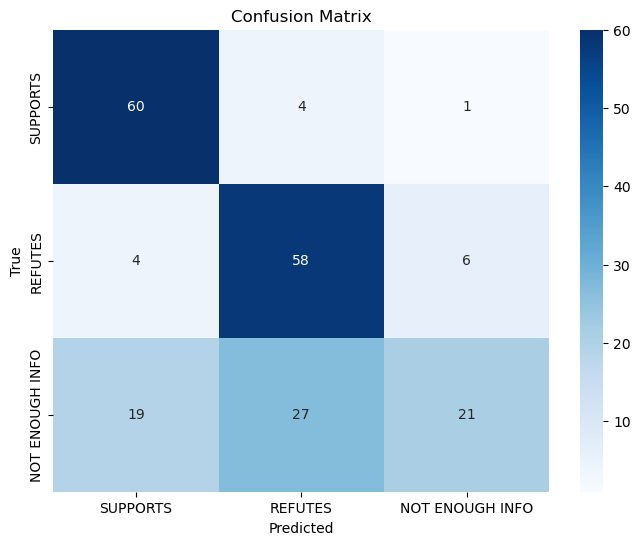

In [61]:
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate, num_samples=200)



# Insights

- The model achieves 69.5% accuracy, with strong performance on SUPPORTS (recall: 0.92) and REFUTES (recall: 0.85), indicating reliable handling of verifiable claims.
- However, NOT ENOUGH INFO remains a weak point, with a low recall of 0.31—many NEI instances are misclassified as REFUTES (27 cases) or SUPPORTS (19 cases).
- Precision across all classes is reasonably balanced (≥0.65), resulting in an overall macro F1-score of 0.66.
- The confusion matrix reflects a trend toward over-attributing labels rather than abstaining. This pattern suggests improved prompt calibration or better evidence retrieval could boost NEI classification


#### Without RAG. 

Progress: 100 / 100
✅ Accuracy: 0.5400

📊 Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.38      0.31      0.34        32
        REFUTES       0.54      0.62      0.58        34
       SUPPORTS       0.66      0.68      0.67        34

       accuracy                           0.54       100
      macro avg       0.53      0.54      0.53       100
   weighted avg       0.53      0.54      0.53       100



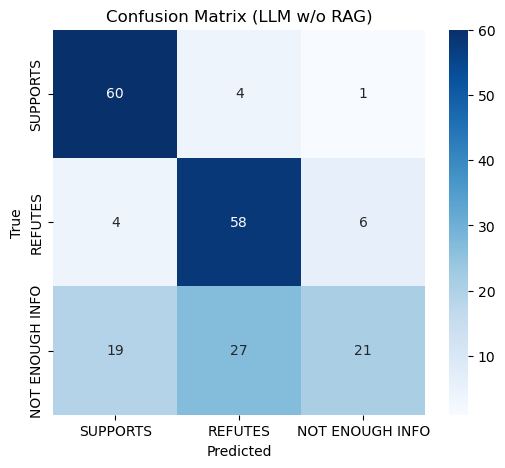

In [62]:

# --- Load Dataset (100 claims) ---
eval_subset = validation.select(range(100))


# --- Prompt Template ---
prompt_template_temp = """<|im_start|>system
You are a fact-checking assistant. Classify the claim based only on the evidence. Respond with exactly one of: SUPPORTS, REFUTES, or NOT ENOUGH INFO.<|im_end|>
<|im_start|>user
Claim: {question}

Answer with one of: SUPPORTS / REFUTES / NOT ENOUGH INFO.
<|im_end|>
<|im_start|>assistant
"""

# --- Run Predictions ---
true_labels_wp = []
pred_labels_wo = []

for done, sample in enumerate(eval_subset):
    claim = sample['claim']
    true_label = sample['label'].upper()
    
    prompt = prompt_template_temp.format(question=claim)
    response = gen_pipeline(prompt, do_sample=False)[0]['generated_text'].upper()
    pred_label = extract_label_from_answer_block(response)
    # print(true_label, pred_label, "\n\n")
    true_labels_wp.append(true_label)
    pred_labels_wo.append(pred_label)
    print(f"Progress: {done + 1} / {len(eval_subset)}", end="\r", flush=True)
    

# --- Evaluation ---
accuracy = accuracy_score(true_labels_wp, pred_labels_wo)
print(f"\n✅ Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", classification_report(true_labels_wp, pred_labels_wo))

# --- Confusion Matrix ---
labels = ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (LLM w/o RAG)")
plt.show()



**Conclusion**
- RAG boosts factual classification significantly by grounding answers in external evidence — especially for ambiguous claims. The drop in REFUTES F1 shows LLM alone can't reliably infer contradiction without grounding.



# === Visualizations ===

#### Aggregate Average Similarity Across All Claims : How well retriever is doing ?

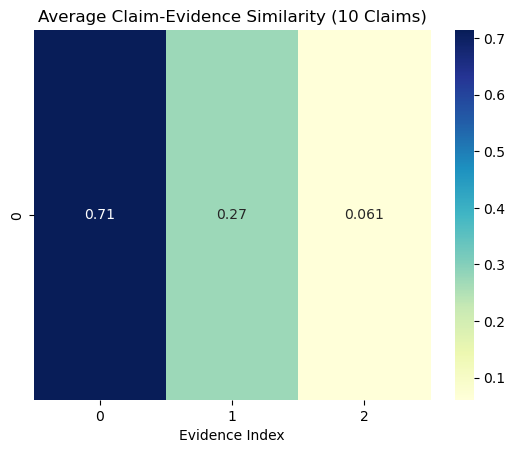

In [63]:
# Compute cosine similarity between each claim and its top-k retrieved evidences, then average the similarity scores across samples.

similarity_matrix = []

for sample in train.select(range(10)):
    claim = sample['claim']
    result = tagged_rag_chain({"query": claim})
    evidence_texts = [doc.page_content for doc in result['source_documents']]

    if not evidence_texts:
        continue  # skip if no retrieved docs

    claim_emb = embedding_model.embed_query(claim)
    evidence_embs = embedding_model.embed_documents(evidence_texts)

    sim_scores = cosine_similarity([claim_emb], evidence_embs)[0]  # shape (top_k,)
    similarity_matrix.append(sim_scores)

# Convert to numpy and pad to same length if needed
max_k = max(len(row) for row in similarity_matrix)
padded_matrix = np.array([np.pad(row, (0, max_k - len(row))) for row in similarity_matrix])
avg_scores = np.mean(padded_matrix, axis=0)

# Plot average similarity
sns.heatmap([avg_scores], annot=True, cmap="YlGnBu")
plt.xlabel("Evidence Index")
plt.title("Average Claim-Evidence Similarity (10 Claims)")
plt.show()

**What it shows**
- The top evidence (index 0) is aligned with claim (0.71). This is quite relevant
- Retriever is doing a good job for the top 1 or 2, but recall could be improved at rank 3–5

### Pie Chart for Prediction Label Distribution for RAG based output

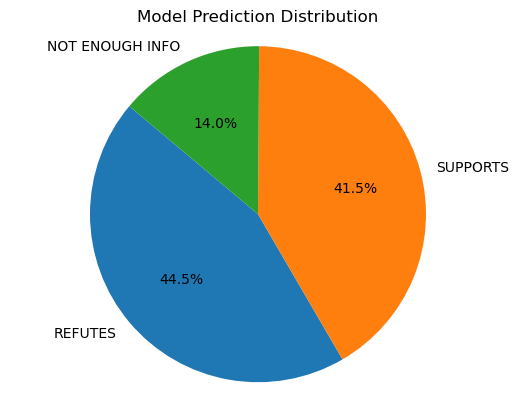

In [64]:

label_counts = Counter(pred_labels)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Model Prediction Distribution")
plt.axis('equal')
plt.show()


### True vs Predicted Label Distribution for RAG based output

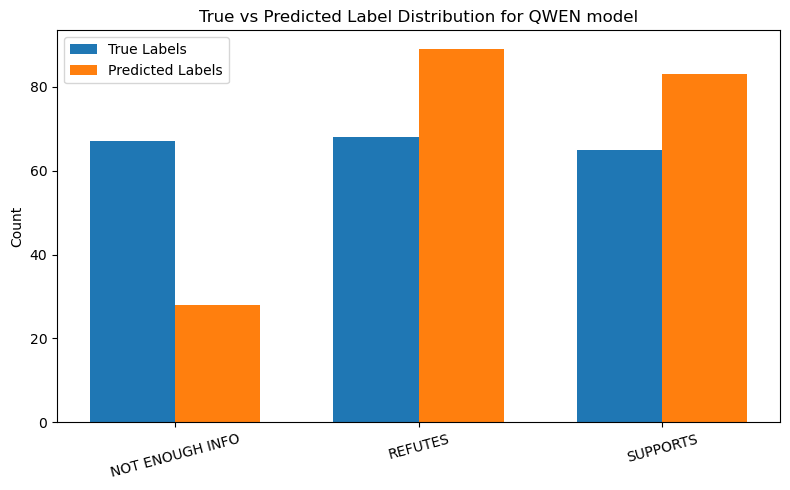

In [65]:
# Count frequencies
true_counts = Counter(true_labels)
pred_counts = Counter(pred_labels)

# Ensure consistent label order
all_labels = sorted(list(set(true_counts.keys()) | set(pred_counts.keys())))

true_values = [true_counts.get(label, 0) for label in all_labels]
pred_values = [pred_counts.get(label, 0) for label in all_labels]

# Bar plot setup
x = np.arange(len(all_labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, true_values, width, label="True Labels")
plt.bar(x + width/2, pred_values, width, label="Predicted Labels")

plt.ylabel("Count")
plt.title("True vs Predicted Label Distribution for QWEN model")
plt.xticks(x, all_labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()


### Refer Project report for Analysis
- The model overpredicts REFUTES and SUPPORTS, while significantly underpredicting NOT ENOUGH INFO.
- This suggests a tendency to assign assertive labels even when evidence may be insufficient.

## == RAG statistics via RAGAS ======

#### Successful Integration of RAGAs with QWEN LLM

- Since it takes a long time, we evaluate only a few claims to get the RAGAS metrics 


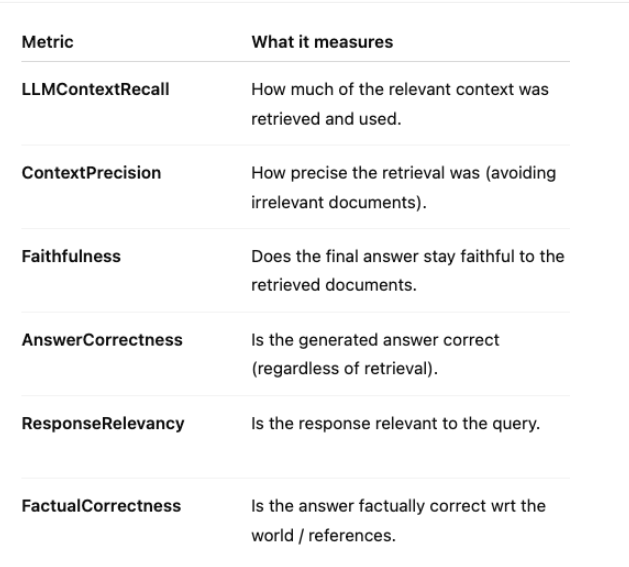

In [41]:
class RAGASLLM(LLM):
    tokenizer: AutoTokenizer = None
    model: AutoModelForCausalLM = None

    def __init__(self, _model, tokenizer):
        super().__init__()
        self.model = _model
        self.tokenizer = tokenizer

    def _call(self, prompt: str, stop: Optional[List[str]] = None,
              run_manager: Optional[CallbackManagerForLLMRun] = None, **kwargs: Any) -> str:
        messages = [{"role": "user", "content": prompt}]
        input_ids = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.tokenizer([input_ids], return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(inputs.input_ids, max_new_tokens=512)
        generated = outputs[:, inputs.input_ids.shape[-1]:]
        return self.tokenizer.decode(generated[0], skip_special_tokens=True)

    @property
    def _llm_type(self) -> str:
        return "qwen2"

In [42]:
class RagasEmbedding(BaseRagasEmbeddings):
    def __init__(self, sentence_model, batch_size=256):
        self.model = sentence_model
        self.batch_size = batch_size

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.model.encode(texts, batch_size=self.batch_size, show_progress_bar=False).tolist()

    def embed_query(self, text: str) -> List[float]:
        return self.model.encode([text], show_progress_bar=False)[0].tolist()

    async def aembed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.embed_documents(texts)

    async def aembed_query(self, text: str) -> List[float]:
        return self.embed_query(text)

In [43]:


def generate_ragas_dataset(rag_chain, dataset, num_samples=100, start_idx=0, verbose=True):
    """
    Generate a RAGAS-compatible Dataset from a LangChain RAG pipeline.

    Args:
        rag_chain: LangChain RetrievalQA or custom RAG chain.
        dataset: HuggingFace Dataset (or list of dicts) with 'claim' and 'label' fields.
        num_samples: Number of samples to generate (default: 100).
        start_idx: Index to start from in the dataset (default: 0).
        verbose: Whether to print progress/errors (default: True).

    Returns:
        A HuggingFace Dataset compatible with RAGAS evaluation.
    """

    questions = []
    answers = []
    contexts_list = []
    ground_truths = []

    selected_data = dataset.select(range(start_idx, start_idx + num_samples))
    done = 0
    for sample in selected_data:
        claim = sample['claim']
        actual_label = sample['label']
        
        try:
            result = rag_chain({"query": claim})
            model_answer = result['result']
            doc_texts = [doc.page_content for doc in result['source_documents']]

            # Append to lists
            questions.append(claim)
            answers.append(model_answer)
            contexts_list.append(doc_texts)
            ground_truths.append(actual_label)
            print(f"Progress: {done + 1} / {num_samples}", end="\r", flush=True)
            done += 1
        except Exception as e:
            if verbose:
                print(f" Error on sample: {claim[:30]}... → {str(e)}")

    # Convert to HuggingFace Dataset
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts_list,
        "ground_truth": ground_truths
    }
    
    return Dataset.from_dict(data)

In [ ]:
ragas_dataset = generate_ragas_dataset(
    rag_chain=tagged_rag_chain,
    dataset=train,
    num_samples=3,      # how many claims to run
    start_idx=0,          # from where in dataset
    verbose=True          # print errors if any
)

In [69]:
run_config = RunConfig(timeout=800, max_wait=800)

ragas_embedding_model = RagasEmbedding(sentence_transformer)
ragas_llm = LangchainLLMWrapper(RAGASLLM(model, tokenizer), run_config)

ragas_result = evaluate(
    dataset=ragas_dataset,
    metrics=[
        LLMContextRecall(),
        ContextPrecision(),
        Faithfulness(),
        AnswerCorrectness(),
        ResponseRelevancy(),
        FactualCorrectness()
    ],
    llm=ragas_llm,
    embeddings=ragas_embedding_model,
    run_config=run_config
)



Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [70]:
print(ragas_result.to_pandas())

                                          user_input  \
0  The number of new cases of shingles per year e...   
1                    Gabrielle Union was in a movie.   
2                Eleveneleven was founded by a chef.   

                                  retrieved_contexts  \
0  [shingles. the number of new cases per year ra...   
1  [gabrielle union. she costarred in film the bi...   
2  [eleveneleven. eleveneleven is a record label ...   

                                            response reference  \
0  <|im_start|>system\nYou are a fact-checking as...  SUPPORTS   
1  <|im_start|>system\nYou are a fact-checking as...  SUPPORTS   
2  <|im_start|>system\nYou are a fact-checking as...   REFUTES   

   context_recall  context_precision  faithfulness  answer_correctness  \
0             1.0                1.0           1.0            0.435391   
1             1.0                1.0           1.0            0.381837   
2             0.0                1.0           1.0            0

In [71]:
ragas_result.to_pandas()


user_input  \
0  The number of new cases of shingles per year e...   
1                    Gabrielle Union was in a movie.   
2                Eleveneleven was founded by a chef.   

                                  retrieved_contexts  \
0  [shingles. the number of new cases per year ra...   
1  [gabrielle union. she costarred in film the bi...   
2  [eleveneleven. eleveneleven is a record label ...   

                                            response reference  \
0  <|im_start|>system\nYou are a fact-checking as...  SUPPORTS   
1  <|im_start|>system\nYou are a fact-checking as...  SUPPORTS   
2  <|im_start|>system\nYou are a fact-checking as...   REFUTES   

   context_recall  context_precision  faithfulness  answer_correctness  \
0             1.0                1.0           1.0            0.435391   
1             1.0                1.0           1.0            0.381837   
2             0.0                1.0           1.0            0.123460   

   answer_relevancy  factual_correctness(mode=f1)  
0          0.852923                           1.0  
1          0.906163                           1.0  
2          0.910416                           0.0

#### RAGAS :  saliency heatmap per question

=== Question 0: The number of new cases of shingles per year extends from 1.2–3.4 per 1,000 among healthy individuals. ===
Faithfulness Score: 1.0000
Context Recall Score: 1.0000


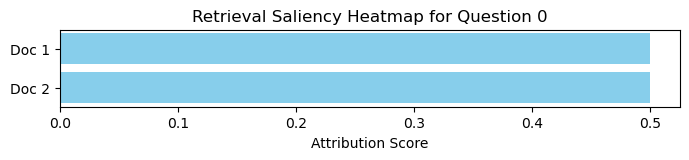

--------------------------------------------------------------------------------
=== Question 1: Gabrielle Union was in a movie. ===
Faithfulness Score: 1.0000
Context Recall Score: 1.0000


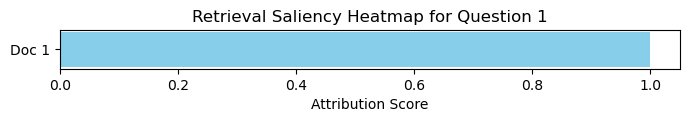

--------------------------------------------------------------------------------
=== Question 2: Eleveneleven was founded by a chef. ===
Faithfulness Score: 1.0000
Context Recall Score: 0.0000


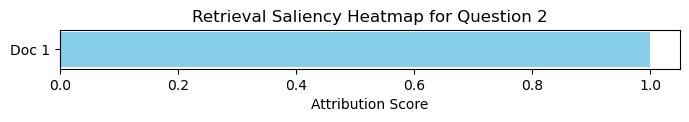

--------------------------------------------------------------------------------


In [94]:
for idx, row in enumerate(ragas_dataset):

    print(f"=== Question {idx}: {row['question']} ===")

    # Get Faithfulness and Context Recall score for this example
    faithfulness_score = ragas_result['faithfulness'][idx]
    context_recall_score = ragas_result['context_recall'][idx]

    print(f"Faithfulness Score: {faithfulness_score:.4f}")
    print(f"Context Recall Score: {context_recall_score:.4f}")

    # Retrieved contexts for this question
    retrieved_chunks = row['contexts']

    # Build dummy "saliency" score for each context (for now, equal scores)
    # Later you can replace this with better logic
    chunk_saliency = [1/len(retrieved_chunks)] * len(retrieved_chunks)

    # Plotting the saliency
    fig, ax = plt.subplots(figsize=(8, 0.5 * len(retrieved_chunks)))

    ax.barh(
        y=[f"Doc {i+1}" for i in range(len(retrieved_chunks))],
        width=chunk_saliency,
        color='skyblue'
    )

    ax.set_xlabel("Attribution Score")
    ax.set_title(f"Retrieval Saliency Heatmap for Question {idx}")
    plt.gca().invert_yaxis()  # Doc 1 on top

    plt.show()

    print("-" * 80)

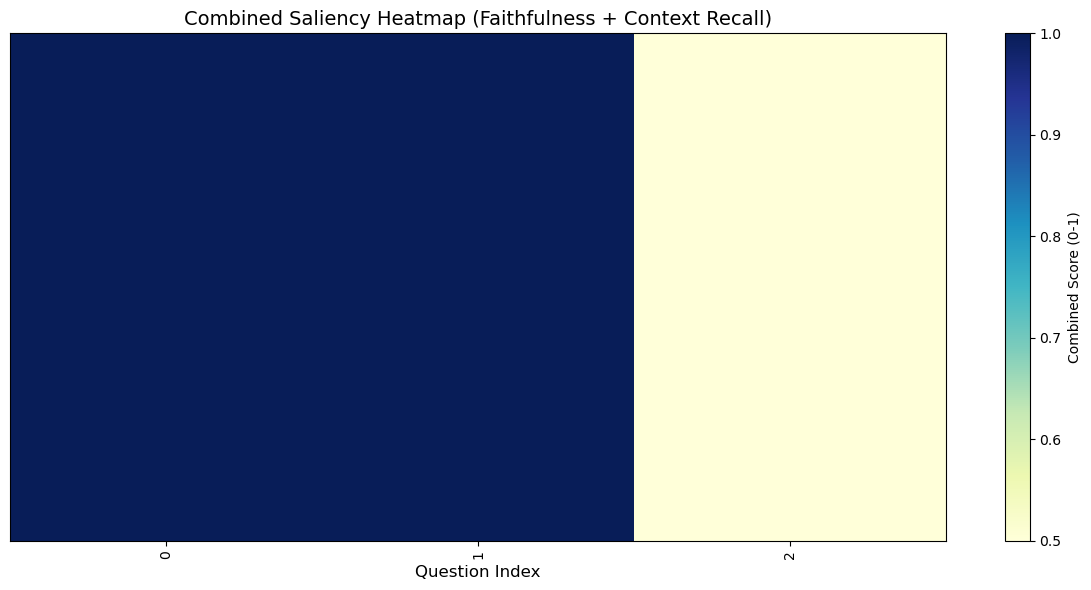

In [95]:
# Assuming you already have evaluated ragas_result
faithfulness_scores = ragas_result['faithfulness']
context_recall_scores = ragas_result['context_recall']

# Combine them: simple average (or weighted sum)
combined_scores = []
for f, c in zip(faithfulness_scores, context_recall_scores):
    combined = 0.5 * f + 0.5 * c  # Equal weight
    combined_scores.append(combined)

# Make a heatmap-friendly format
combined_scores = np.array(combined_scores)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

cax = ax.imshow(
    combined_scores.reshape(1, -1),  # Make it a 1-row "heatmap"
    cmap='YlGnBu',
    aspect="auto"
)

# Labels
ax.set_title("Combined Saliency Heatmap (Faithfulness + Context Recall)", fontsize=14)
ax.set_xlabel("Question Index", fontsize=12)
ax.set_yticks([])
ax.set_xticks(np.arange(len(combined_scores)))
ax.set_xticklabels(np.arange(len(combined_scores)))
plt.xticks(rotation=90)

# Colorbar
fig.colorbar(cax, orientation='vertical', label='Combined Score (0-1)')

plt.tight_layout()
plt.show()

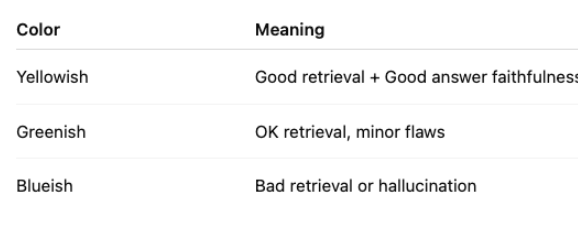

##  Run RAGAS on 25 samples --- Base QWEN Model

In [44]:
ragas_dataset = generate_ragas_dataset(
    rag_chain=tagged_rag_chain,
    dataset=train,
    num_samples=25,      # how many claims to run
    start_idx=0,          # from where in dataset
    verbose=True          # print errors if any
)

Progress: 25 / 25

In [45]:
run_config = RunConfig(timeout=800, max_wait=800)
model.config.pad_token_id = tokenizer.eos_token_id
ragas_embedding_model = RagasEmbedding(sentence_transformer)
ragas_llm = LangchainLLMWrapper(RAGASLLM(model, tokenizer), run_config)

ragas_result_25 = evaluate(
    dataset=ragas_dataset,
    metrics=[
        Faithfulness(),
        ResponseRelevancy()
    ],
    llm=ragas_llm,
    embeddings=ragas_embedding_model,
    run_config=run_config
)


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Exception raised in Job[16]: TimeoutError()


In [46]:
ragas_result_25

{'faithfulness': 0.8299, 'answer_relevancy': 0.8286}

In [47]:
ragas_result_25.to_pandas()

user_input  \
0   The number of new cases of shingles per year e...   
1                     Gabrielle Union was in a movie.   
2                 Eleveneleven was founded by a chef.   
3   Cosmos: A Spacetime Odyssey secured studio sup...   
4   The World According to Paris starred Hilton's ...   
5        The Germanic peoples are also called Gothic.   
6                          Margot Kidder is a person.   
7   Chokher Bali was nominated for a Golden Leopar...   
8                     Usain Bolt won at the Olympics.   
9   The industry that the company The New York Tim...   
10                     Life After Death is by Eminem.   
11     The Coen brothers were the directors of Fargo.   
12                         Bob Arum is from New York.   
13                       Lance Armstrong had a puppy.   
14  Sparta won the Peloponnesian War at the great ...   
15         Sister Act grossed $231 million worldwide.   
16                             Tennis is not a sport.   
17       NSYNC was a vocal group that formed in 1998.   
18                         Kick-Ass is a horror film.   
19  Boeing 737s served the same markets that 757 a...   
20       Sindh borders Indian states and is in India.   
21                           Jimmy Carter was a king.   
22                     Sean Connery acted in a movie.   
23                   Views had the album "Pop Style."   
24                         Joan Cusack was in a film.   

                                   retrieved_contexts  \
0   [shingles. the number of new cases per year ra...   
1   [gabrielle union. she costarred in film the bi...   
2   [eleveneleven. eleveneleven is a record label ...   
3   [seth macfarlane. macfarlane served as executi...   
4   [the world according to paris. it was filmed f...   
5   [germanic peoples. the germanic peoples also c...   
6   [margot kidder. in 2015 , she won an emmy awar...   
7   [chokher bali film. chokher bali won the natio...   
8   [usain bolt. bolt is the only sprinter to win ...   
9   [newspaper. the late 2000s early 2010s global ...   
10  [life after death. a double album , it was rel...   
11  [coen brothers. they have been nominated for t...   
12  [bob arum. he also worked for the us attorney ...   
13  [lance armstrong. between 2010 and 2011 , he r...   
14  [peloponnesian war. the peloponnesian war 431 ...   
15  [sister act. one of the most financially succe...   
16  [tennis. tennis is a racket sport that can be ...   
17  [nsync. nsync sometimes stylized as nsync or n...   
18  [kickass film. kickass is a 2010 britishameric...   
19  [boeing 737. many 737s serve markets previousl...   
20  [india. india , officially the republic of ind...   
21  [electoral history of jimmy carter. chevene ki...   
22  [sean connery. his film career also includes s...   
23  [views album. views was nominated for album of...   
24  [joan cusack. she is also known as the voice o...   

                                             response        reference  \
0   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
1   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
2   <|im_start|>system\nYou are a fact-checking as...          REFUTES   
3   <|im_start|>system\nYou are a fact-checking as...  NOT ENOUGH INFO   
4   <|im_start|>system\nYou are a fact-checking as...  NOT ENOUGH INFO   
5   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
6   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
7   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
8   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
9   <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
10  <|im_start|>system\nYou are a fact-checking as...          REFUTES   
11  <|im_start|>system\nYou are a fact-checking as...         SUPPORTS   
12  <|im_start|>system\nYou are a fact-checking as...  NOT ENOUGH INFO   
13  <|im_start|>system\nYou are a fact-ch

Number of samples (including zeros): 25


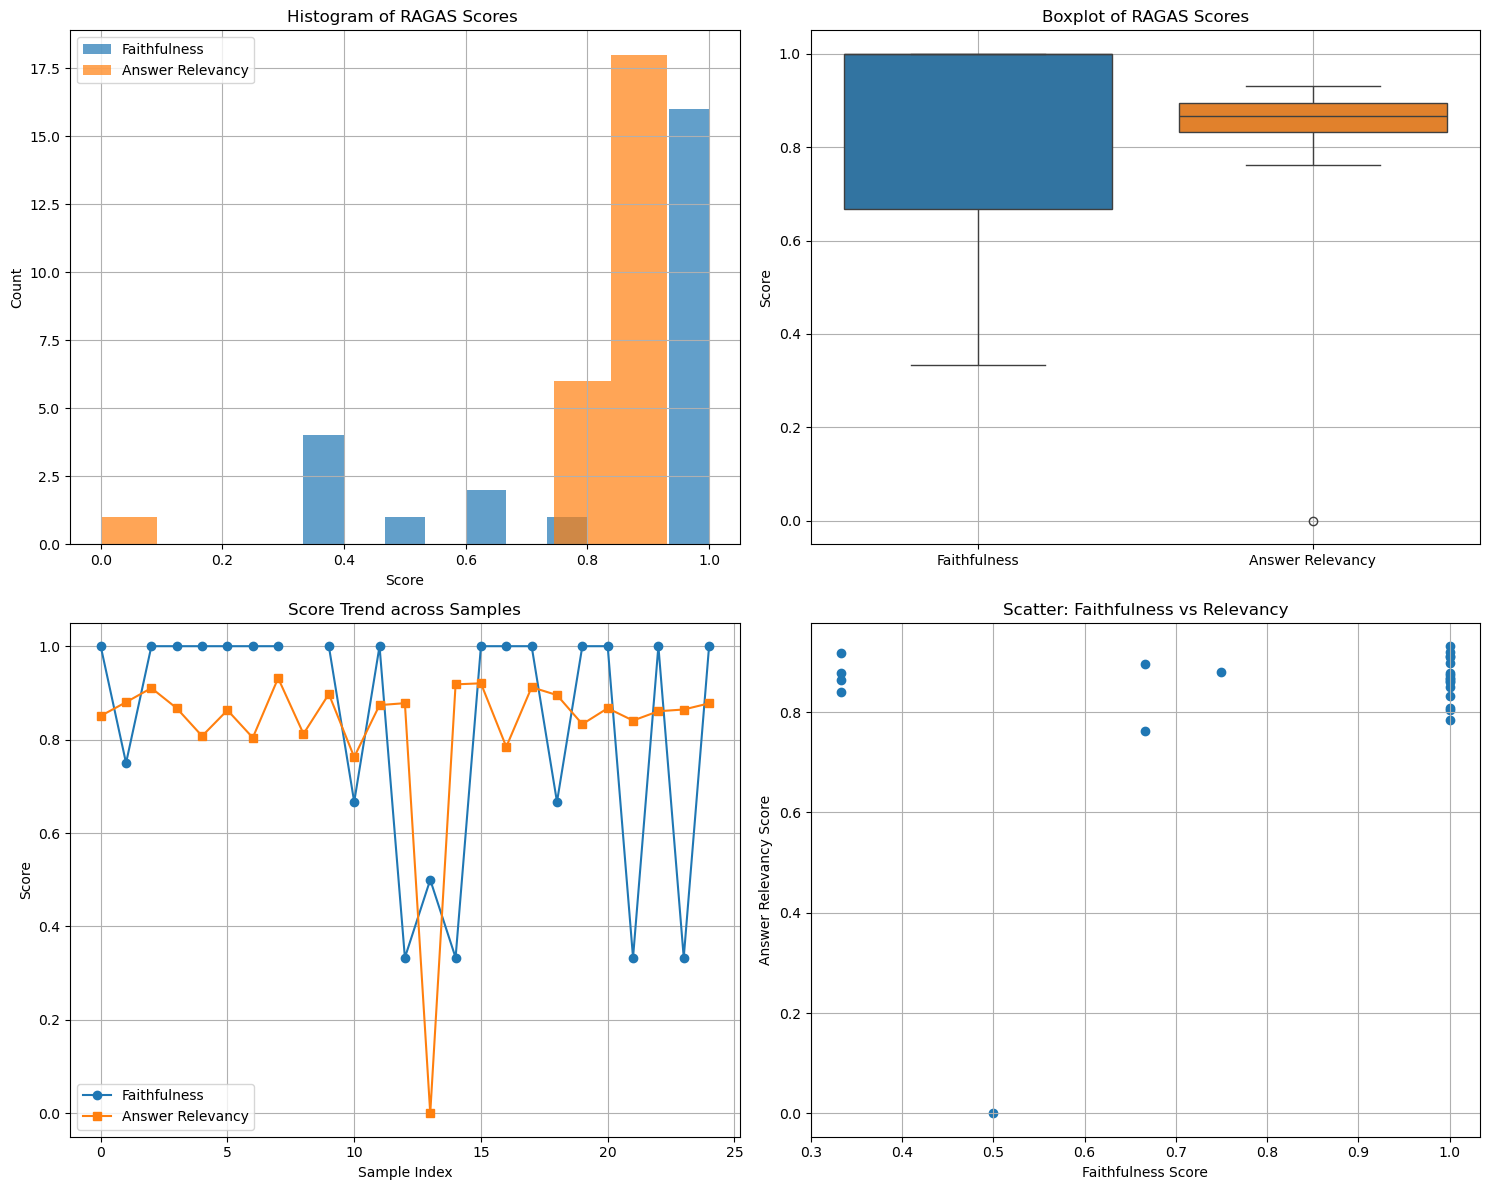

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

faithfulness_scores = ragas_result_25['faithfulness']
answer_relevancy_scores = ragas_result_25['answer_relevancy']

faithfulness_scores = np.array(faithfulness_scores)
answer_relevancy_scores = np.array(answer_relevancy_scores)

print(f"Number of samples (including zeros): {len(faithfulness_scores)}")

# ---- 2x2 Plot Grid ----
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram
axes[0, 0].hist(faithfulness_scores, bins=10, alpha=0.7, label='Faithfulness')
axes[0, 0].hist(answer_relevancy_scores, bins=10, alpha=0.7, label='Answer Relevancy')
axes[0, 0].set_title("Histogram of RAGAS Scores ")
axes[0, 0].set_xlabel("Score")
axes[0, 0].set_ylabel("Count")
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Boxplot
sns.boxplot(data=[faithfulness_scores, answer_relevancy_scores], ax=axes[0, 1])
axes[0, 1].set_xticklabels(['Faithfulness', 'Answer Relevancy'])
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title("Boxplot of RAGAS Scores")
axes[0, 1].grid(True)

# 3. Line Plot
sample_idx = np.arange(len(faithfulness_scores))
axes[1, 0].plot(sample_idx, faithfulness_scores, marker='o', label='Faithfulness')
axes[1, 0].plot(sample_idx, answer_relevancy_scores, marker='s', label='Answer Relevancy')
axes[1, 0].set_xlabel("Sample Index")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_title("Score Trend across Samples")
axes[1, 0].legend()
axes[1, 0].grid(True)

# 4. Scatter Plot
axes[1, 1].scatter(faithfulness_scores, answer_relevancy_scores)
axes[1, 1].set_xlabel("Faithfulness Score")
axes[1, 1].set_ylabel("Answer Relevancy Score")
axes[1, 1].set_title("Scatter: Faithfulness vs Relevancy")
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()



### Insights

- QWEN RAG achieved higher mean scores on both faithfulness (0.83) and answer relevancy (0.82), indicating strong retrieval grounding and response alignment. 